# Heart Failure Readmission Prediction Models

This notebook builds and evaluates machine learning models to predict 30-day readmissions for heart failure patients.

## Goals:
1. Train multiple model types (Logistic Regression, Random Forest, XGBoost)
2. Compare model performance using appropriate metrics
3. Analyze feature importance
4. Save the best performing model

In [52]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shap

# Add the src directory to Python path
notebook_dir = Path(r'c:/Users/tyagi/Desktop/heartbyte/notebooks')
src_dir = notebook_dir.parent / 'src'
sys.path.append(str(src_dir))

from data_loader import MIMICDataLoader
from data_processing import preprocess_features, prepare_model_data, calculate_readmissions, clean_features_for_modeling
from modeling import (
    train_logistic_regression, train_random_forest, train_xgboost,
    evaluate_model, plot_model_evaluation, save_model, 
    explain_model_with_shap, plot_shap_dependence
)

# Configure plotting
%matplotlib inline
plt.style.use('default')
sns.set_theme()

## 1. Load and Preprocess Data

First, we'll load the heart failure patient data and preprocess it for modeling.

In [53]:
# Load heart failure patient data
loader = MIMICDataLoader()
loader.load_data()
hf_patients, hf_admissions, hf_diagnoses, hf_procedures = loader.filter_heart_failure_patients()

# Calculate readmissions
hf_admissions = calculate_readmissions(hf_admissions)

# Create feature dataset (from 02_data_analysis.ipynb)
def create_features(patients, admissions, diagnoses, procedures):
    # Start with admissions data
    features = admissions.copy()
    
    # Add patient demographics and calculate age
    patient_features = patients[['subject_id']].copy()
    
    # Add gender if available
    if 'gender' in patients.columns:
        patient_features['gender'] = patients['gender']
        features = features.merge(patient_features[['subject_id', 'gender']], 
                                on='subject_id', 
                                how='left')
    
    # Calculate age if DOB is available
    if 'dob' in patients.columns and 'admittime' in admissions.columns:
        # Convert dates to datetime
        patient_features['dob'] = pd.to_datetime(patients['dob'])
        features['admittime'] = pd.to_datetime(features['admittime'])
        
        # Calculate age using year difference then adjust for month and day
        features = features.merge(patient_features[['subject_id', 'dob']], 
                                on='subject_id', 
                                how='left')
        features['age'] = features.apply(lambda x: 
            (x['admittime'].year - x['dob'].year) - 
            ((x['admittime'].month, x['admittime'].day) < 
             (x['dob'].month, x['dob'].day)), axis=1)
        
        # Drop temporary DOB column
        features = features.drop('dob', axis=1)
    
    # Calculate length of stay if discharge time is available
    if 'dischtime' in features.columns:
        features['dischtime'] = pd.to_datetime(features['dischtime'])
        features['length_of_stay'] = (features['dischtime'] - 
                                     features['admittime']).dt.total_seconds() / (24*60*60)
    
    # Calculate admission count and time since last admission
    features['admission_count'] = features.groupby('subject_id').cumcount() + 1
    
    if 'dischtime' in features.columns:
        features['prev_dischtime'] = features.groupby('subject_id')['dischtime'].shift(1)
        features['days_since_last_admission'] = (features['admittime'] - 
                                                pd.to_datetime(features['prev_dischtime'])).dt.total_seconds() / (24*60*60)
    
    # Count comorbidities per admission
    if 'hadm_id' in diagnoses.columns:
        comorbidity_counts = diagnoses.groupby('hadm_id').size().reset_index(name='num_diagnoses')
        features = features.merge(comorbidity_counts, on='hadm_id', how='left')
    
    # Count procedures per admission if available
    if procedures is not None and 'hadm_id' in procedures.columns:
        procedure_counts = procedures.groupby('hadm_id').size().reset_index(name='num_procedures')
        features = features.merge(procedure_counts, on='hadm_id', how='left')
    
    # Fill missing values
    numerical_columns = ['length_of_stay', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']
    for col in numerical_columns:
        if col in features.columns:
            features[col] = features[col].fillna(0)
    
    return features

# Create feature dataset
features_df = create_features(hf_patients, hf_admissions, hf_diagnoses, hf_procedures)

# Clean features by removing datetime and non-numeric columns
# Use the module function from data_processing
features_df_clean = clean_features_for_modeling(features_df)

# Print info about the cleaning process
datetime_cols = [col for col in features_df.columns if pd.api.types.is_datetime64_any_dtype(features_df[col])]
object_cols = [col for col in features_df.columns if pd.api.types.is_object_dtype(features_df[col])]
other_non_numeric = [col for col in features_df.columns if not pd.api.types.is_numeric_dtype(features_df[col]) 
                    and col not in datetime_cols and col not in object_cols]

if datetime_cols:
    print(f"Removed datetime columns: {datetime_cols}")
if object_cols:
    print(f"Removed object columns: {object_cols}")
if other_non_numeric:
    print(f"Removed other non-numeric columns: {other_non_numeric}")

# Display the columns that remained after cleaning
print(f"\nRemaining features after cleaning: {features_df_clean.shape[1]}")
print(f"Feature columns: {features_df_clean.columns.tolist()}")

# Prepare data for modeling using the cleaned features
X_train, X_test, y_train, y_test = prepare_model_data(
    features_df_clean, 
    target_col='is_readmission', 
    test_size=0.2, 
    random_state=42
)

# Display basic information
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
print(f"Class distribution in training set: \n{y_train.value_counts(normalize=True).round(3)}")

Loaded 58976 admissions
Loaded 46520 patients
Loaded 651047 diagnoses
Loaded 240095 procedures
Found 78963 procedures for heart failure patients
Found 10272 patients with heart failure
These patients had 16756 admissions
Removed datetime columns: ['admittime', 'dischtime', 'next_admittime', 'prev_dischtime']
Removed object columns: ['deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'gender']

Remaining features after cleaning: 13
Feature columns: ['row_id', 'subject_id', 'hadm_id', 'hospital_expire_flag', 'has_chartevents_data', 'days_to_next_admission', 'is_readmission', 'age', 'length_of_stay', 'admission_count', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']
Training set: (13404, 12), Testing set: (3352, 12)
Class distribution in training set: 
is_readmission
0    0.918
1    0.082
Name: proportion, dtype: float64


## 2. Train and Evaluate Models

We'll train three models with different complexity levels:
1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost

In [54]:
# Get feature names for importance analysis
feature_names = X_train.columns.tolist()

# Dictionary to store results
results = {}

# Check for NaN values in training and testing data
print("NaN check in training data:")
print(f"X_train contains NaN: {X_train.isna().any().any()}")
print(f"y_train contains NaN: {y_train.isna().any()}")
print("\nNaN check in testing data:")
print(f"X_test contains NaN: {X_test.isna().any().any()}")
print(f"y_test contains NaN: {y_test.isna().any()}")

if X_train.isna().any().any():
    print("\nFixing NaN values in training data...")
    # Count NaN values in each column
    nan_counts = X_train.isna().sum()
    cols_with_nan = nan_counts[nan_counts > 0]
    print(f"Columns with NaN values:\n{cols_with_nan}")
    
    # Fill NaNs with column means
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())
    
    # Double check
    print(f"\nAfter fixing, X_train contains NaN: {X_train.isna().any().any()}")
    print(f"After fixing, X_test contains NaN: {X_test.isna().any().any()}")

NaN check in training data:
X_train contains NaN: True
y_train contains NaN: False

NaN check in testing data:
X_test contains NaN: True
y_test contains NaN: False

Fixing NaN values in training data...
Columns with NaN values:
days_to_next_admission    8744
dtype: int64

After fixing, X_train contains NaN: False
After fixing, X_test contains NaN: False


### 2.1 Logistic Regression (Baseline Model)

Training Logistic Regression model...

Logistic Regression Performance:
Accuracy: 0.9547
Precision: 0.7778
Recall: 1.0000
F1 Score: 0.8750
ROC AUC: 0.9909


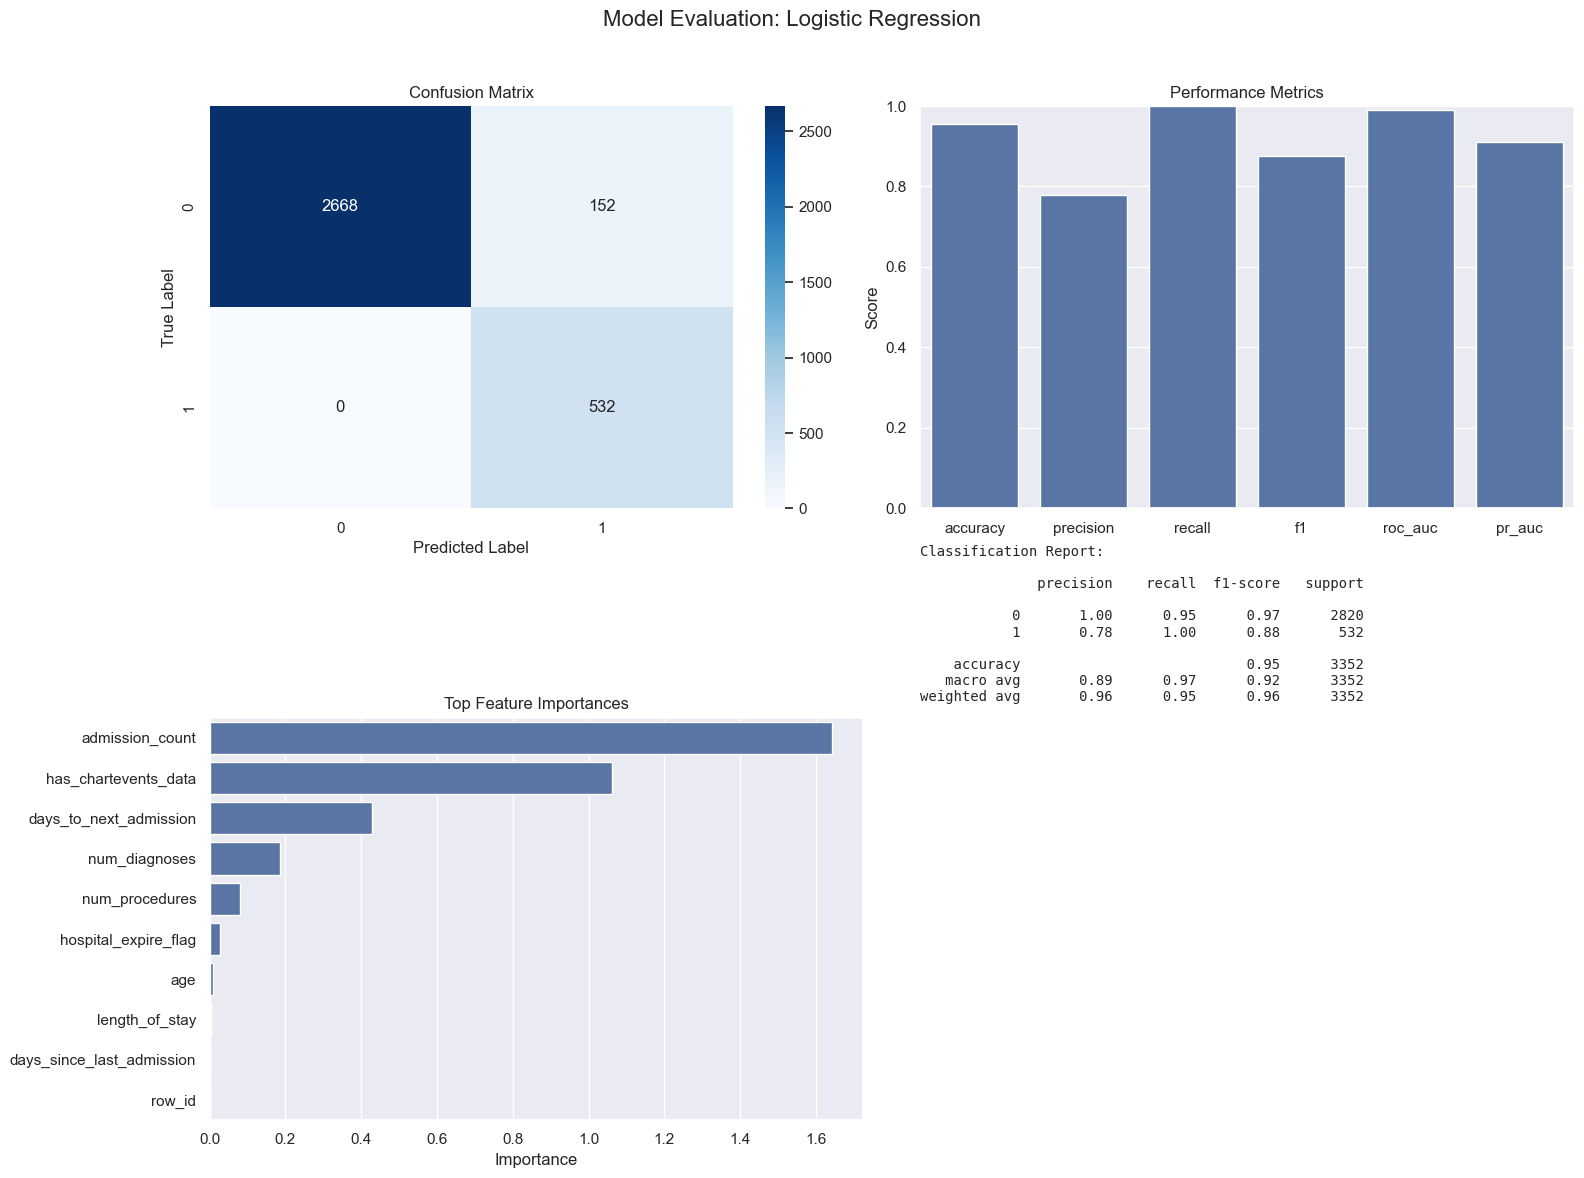

In [55]:
# Train logistic regression model
print("Training Logistic Regression model...")
lr_model = train_logistic_regression(X_train, y_train)

# Evaluate model
lr_results = evaluate_model(lr_model, X_test, y_test, feature_names)
results['logistic_regression'] = lr_results

# Display evaluation
print("\nLogistic Regression Performance:")
print(f"Accuracy: {lr_results['accuracy']:.4f}")
print(f"Precision: {lr_results['precision']:.4f}")
print(f"Recall: {lr_results['recall']:.4f}")
print(f"F1 Score: {lr_results['f1']:.4f}")
print(f"ROC AUC: {lr_results['roc_auc']:.4f}")

# Plot evaluation
plot_model_evaluation(lr_results, "Logistic Regression")

Model Performance Comparison:
           Logistic Regression
accuracy                0.9547
precision               0.7778
recall                  1.0000
f1                      0.8750
roc_auc                 0.9909


<Figure size 1200x800 with 0 Axes>

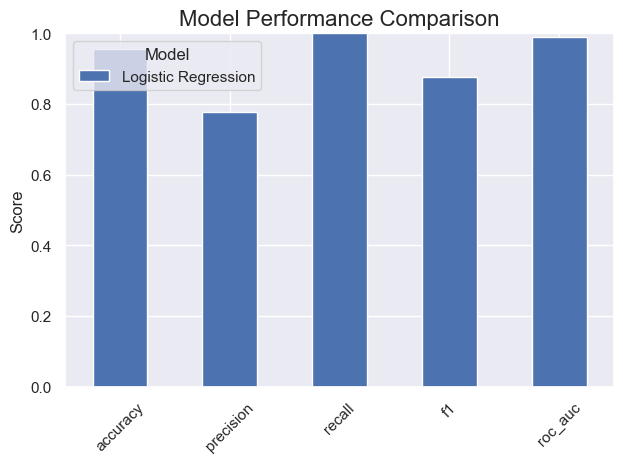

In [56]:
# Compare models based on key metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_data = {
    'Logistic Regression': [results['logistic_regression'][m] for m in metrics],
    # 'Random Forest': [results['random_forest'][m] for m in metrics],
    # 'XGBoost': [results['xgboost'][m] for m in metrics]
}

comparison_df = pd.DataFrame(comparison_data, index=metrics)
comparison_df = comparison_df.round(4)

# Display comparison table
print("Model Performance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Feature Importance Analysis

<Figure size 1400x1000 with 0 Axes>

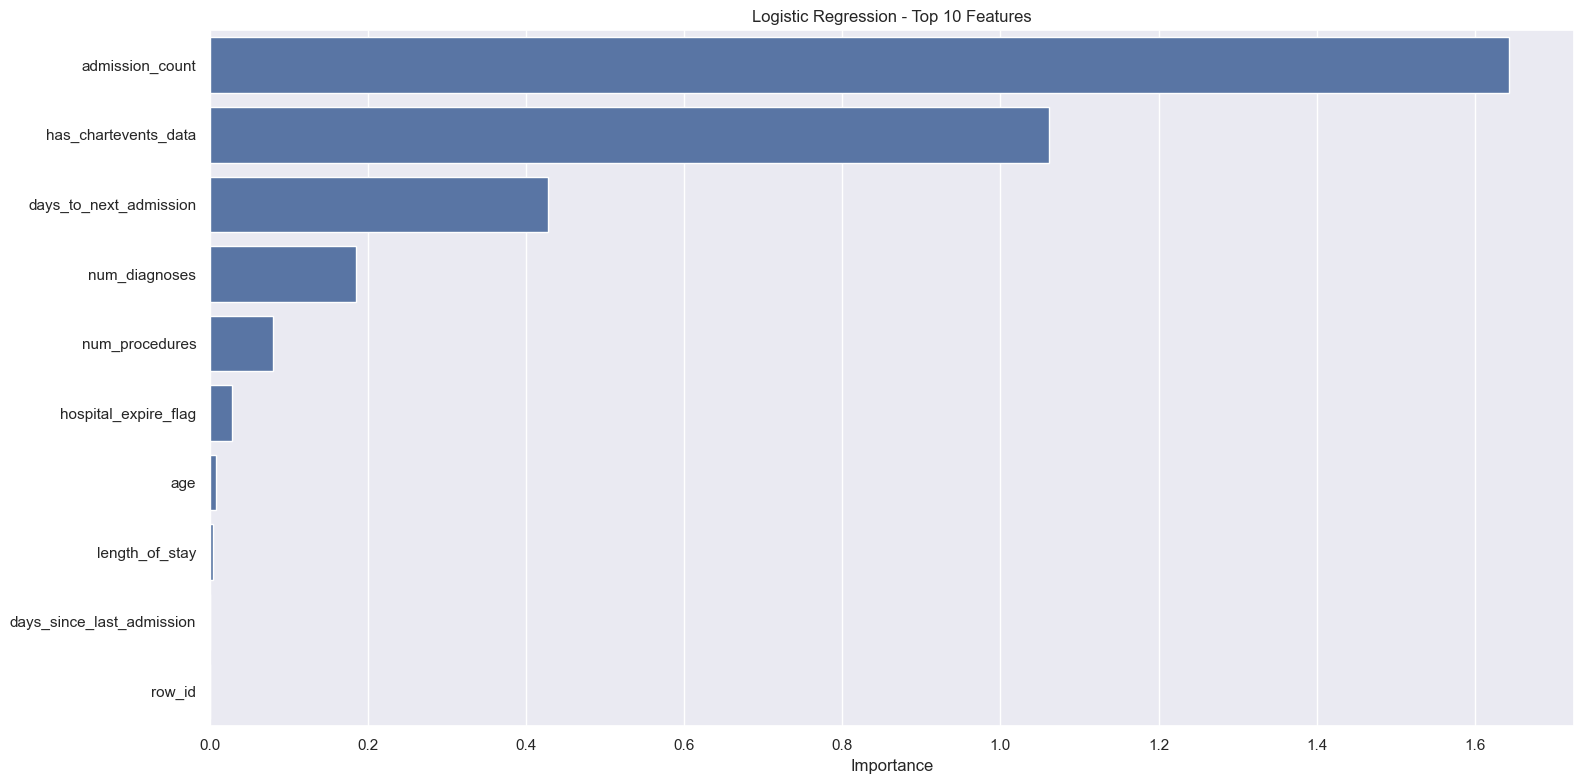

In [57]:
# Compare feature importances across models
plt.figure(figsize=(14, 10))

# Get top 10 features from each model
feature_data = {}
top_n = 10

if 'feature_importance' in results['logistic_regression']:
    lr_fi = results['logistic_regression']['feature_importance']
    feature_data['Logistic Regression'] = {
        'names': lr_fi['names'][:top_n], 
        'values': lr_fi['values'][:top_n]
    }

# if 'feature_importance' in results['random_forest']:
#     rf_fi = results['random_forest']['feature_importance']
#     feature_data['Random Forest'] = {
#         'names': rf_fi['names'][:top_n], 
#         # 'values': rf_fi['values'][:top_n]
    # }

# if 'feature_importance' in results['xgboost']:
#     xgb_fi = results['xgboost']['feature_importance']
#     feature_data['XGBoost'] = {
#         'names': xgb_fi['names'][:top_n], 
#         'values': xgb_fi['values'][:top_n]
#     }

# Plot top features for each model
num_models = len(feature_data)
fig, axes = plt.subplots(1, num_models, figsize=(16, 8))

for i, (model_name, data) in enumerate(feature_data.items()):
    ax = axes[i] if num_models > 1 else axes
    sns.barplot(x=data['values'], y=data['names'], ax=ax)
    ax.set_title(f"{model_name} - Top {top_n} Features")
    ax.set_xlabel('Importance')
    if i > 0 and num_models > 1:
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

## 5. Save Best Model

Based on our evaluation metrics, we'll save the best performing model.

In [58]:
# Determine the best model based on F1 score (balances precision and recall)
f1_scores = {
    'Logistic Regression': results['logistic_regression']['f1'],
    # 'Random Forest': results['random_forest']['f1'],
    # 'XGBoost': results['xgboost']['f1']
}

best_model_name = max(f1_scores, key=f1_scores.get)
print(f"Best model based on F1 score: {best_model_name} (F1 = {f1_scores[best_model_name]:.4f})")

# Save the best model
models = {
    'Logistic Regression': lr_model,
    # 'Random Forest': rf_model,
    # 'XGBoost': xgb_model
}

best_model = models[best_model_name]
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = model_dir / f"readmission_{best_model_name.lower().replace(' ', '_')}_{timestamp}.joblib"

save_model(best_model, model_filename)

Best model based on F1 score: Logistic Regression (F1 = 0.8750)
Model saved to ..\models\readmission_logistic_regression_20250511_151600.joblib


## 6. Model Interpretability with SHAP

Use SHAP (SHapley Additive exPlanations) to interpret the models and understand feature contributions.

In [59]:
def explain_model_with_shap(model, X_data, sample_size=100, plot_type='summary'):
    """
    Create SHAP explanations for a given model.
    
    Args:
        model: Trained model to explain
        X_data: Feature dataset to use for explanations
        sample_size: Number of samples to use (for performance)
        plot_type: Type of SHAP plot to generate
    
    Returns:
        tuple: (explainer, shap_values)
    """
    # Sample data if requested
    if sample_size and sample_size < X_data.shape[0]:
        X_sample = X_data.sample(sample_size, random_state=42)
    else:
        X_sample = X_data
    
    print(f"Generating SHAP values using {X_sample.shape[0]} samples...")
    
    # Create explainer based on model type
    if hasattr(model, 'coef_'):  # Linear models like Logistic Regression
        # For linear models, we can use the faster LinearExplainer
        background = shap.maskers.Independent(X_sample, max_samples=100)
        explainer = shap.LinearExplainer(model, background)
        shap_values = explainer(X_sample)
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_sample)
    else:  # Fallback to KernelExplainer for other models
        # Define a prediction function that outputs probabilities for class 1
        def model_predict(x):
            return model.predict_proba(x)[:, 1]
        
        background = shap.maskers.Independent(X_sample, max_samples=100)
        explainer = shap.KernelExplainer(model_predict, background)
        shap_values = explainer(X_sample)
    
    # Generate the appropriate plot
    if plot_type == 'summary':
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, show=False)
        plt.title("SHAP Feature Importance")
        plt.tight_layout()
        plt.show()
    elif plot_type == 'bar':
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
        plt.title("SHAP Feature Importance (Bar)")
        plt.tight_layout()
        plt.show()
    elif plot_type == 'dependence':
        # Find most important feature
        if isinstance(shap_values, list):
            vals = np.abs(shap_values[1]).mean(0)
        else:
            vals = np.abs(shap_values).mean(0)
        
        feature_importance = pd.DataFrame({
            'feature': X_sample.columns,
            'importance': vals
        }).sort_values('importance', ascending=False)
        
        top_feature = feature_importance.iloc[0]['feature']
        shap.dependence_plot(top_feature, shap_values, X_sample)
    
    return explainer, shap_values

Generating SHAP values using 500 samples...


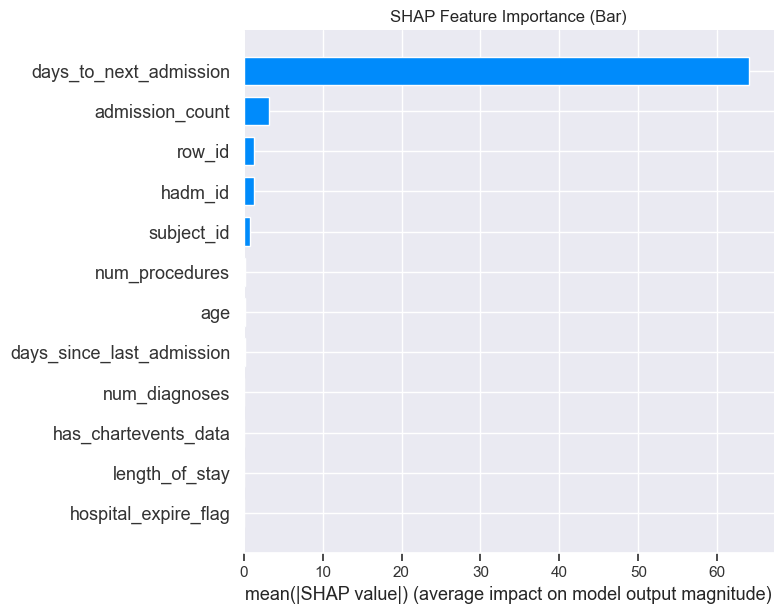

(<shap.explainers._linear.LinearExplainer at 0x2785e4ef610>,
 .values =
 array([[ 0.18838796,  0.21242244, -1.58347539, ...,  0.14526319,
         -0.15348718,  0.31148961],
        [-1.24396535,  0.75853198, -0.45606926, ..., -0.18689602,
          0.03143713, -0.17269113],
        [-1.23023867,  0.75371336, -2.54316952, ...,  0.02151603,
          0.03143713, -0.25338792],
        ...,
        [ 1.3308542 , -0.22578795,  2.36008836, ..., -0.49397398,
          0.03143713,  0.87636715],
        [ 0.36215753,  0.14533978, -1.03695744, ..., -0.05846092,
          0.03143713, -0.09199434],
        [ 0.82683096, -0.02794134,  0.45626102, ...,  0.13785966,
          0.03143713,  0.55357999]], shape=(500, 12))
 
 .base_values =
 array([-83.71405049, -83.71405049, -83.71405049, -83.71405049,
        -83.71405049, -83.71405049, -83.71405049, -83.71405049,
        -83.71405049, -83.71405049, -83.71405049, -83.71405049,
        -83.71405049, -83.71405049, -83.71405049, -83.71405049,
        -83

In [60]:
# Generate bar plot for absolute SHAP value importance
explain_model_with_shap(best_model, X_test, sample_size=sample_size, plot_type='bar')

In [61]:
# Modified beeswarm plot to handle multiple dimensions and shape mismatches
def plot_shap_beeswarm(explainer, shap_values, X_sample):
    """
    Create a SHAP beeswarm plot that handles multi-dimensional values and shape mismatches
    """
    # For models that return multiple outputs (like multi-class or complex models)
    if isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and len(shap_values.shape) > 2):
        # For binary classification, we usually want the positive class (index 1)
        # But some models return just one set of values for binary classification
        if len(shap_values) == 2:
            print("Using positive class (index 1) for beeswarm plot")
            values_to_plot = shap_values[1]
        else:
            print("Using first output for beeswarm plot")
            values_to_plot = shap_values[0]
    else:
        # Single dimension values
        values_to_plot = shap_values
    
    # Check for dimension mismatch and reshape if necessary
    if values_to_plot.shape[0] != X_sample.shape[0]:
        print(f"Warning: Shape mismatch - SHAP values shape {values_to_plot.shape}, data shape {X_sample.shape}")
        
        # If we have a different number of rows, try to use as many as we can
        min_rows = min(values_to_plot.shape[0], X_sample.shape[0])
        values_to_plot = values_to_plot[:min_rows]
        X_sample = X_sample.iloc[:min_rows]
        print(f"Using first {min_rows} rows from both datasets")
    
    # Check if columns match up
    if len(values_to_plot.shape) > 1 and values_to_plot.shape[1] != X_sample.shape[1]:
        print(f"Warning: Feature count mismatch - SHAP values have {values_to_plot.shape[1]} features, data has {X_sample.shape[1]} features")
        
        # Two options:
        # 1. If SHAP values have more features, truncate them
        if values_to_plot.shape[1] > X_sample.shape[1]:
            values_to_plot = values_to_plot[:, :X_sample.shape[1]]
            print(f"Truncated SHAP values to match {X_sample.shape[1]} features")
        # 2. If data has more features, use only the first n features that match SHAP values
        else:
            X_sample = X_sample.iloc[:, :values_to_plot.shape[1]]
            print(f"Using only the first {values_to_plot.shape[1]} features from the data")
    
    # Create an Explanation object with the right dimensionality
    try:
        explanation = shap.Explanation(
            values=values_to_plot,
            data=X_sample.values,  # Use .values to ensure numpy array
            feature_names=X_sample.columns.tolist()
        )
        
        # Create the plot
        shap.plots.beeswarm(explanation)
    except Exception as e:
        print(f"Error creating SHAP explanation: {str(e)}")
        print("Attempting alternative approach...")
        
        # Alternative approach using raw SHAP plotting
        plt.figure(figsize=(10, 8))
        shap.summary_plot(values_to_plot, X_sample, plot_type="bar", show=False)
        plt.title(f"Feature Importance Summary (Bar Plot)")
        plt.tight_layout()
        plt.show()



## Testing for Model Overfitting
===== Overfitting Analysis for Logistic Regression =====

Training vs Testing Performance:
            accuracy  precision  recall      f1  roc_auc
Training      0.9925     0.9159     1.0  0.9561   0.9996
Testing       0.9547     0.7778     1.0  0.8750   0.9909
Difference    0.0378     0.1381     0.0  0.0811   0.0087


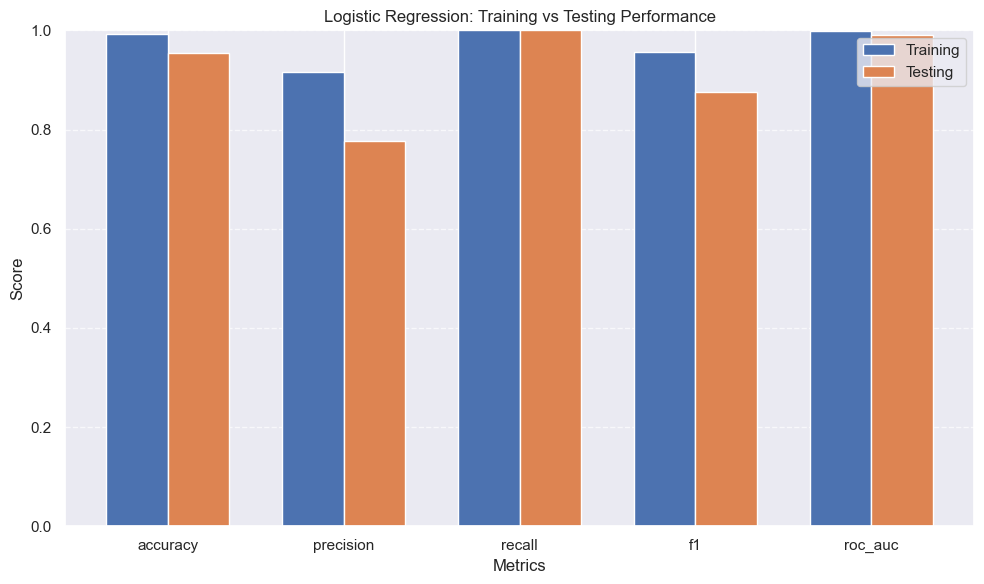


Generating learning curves...


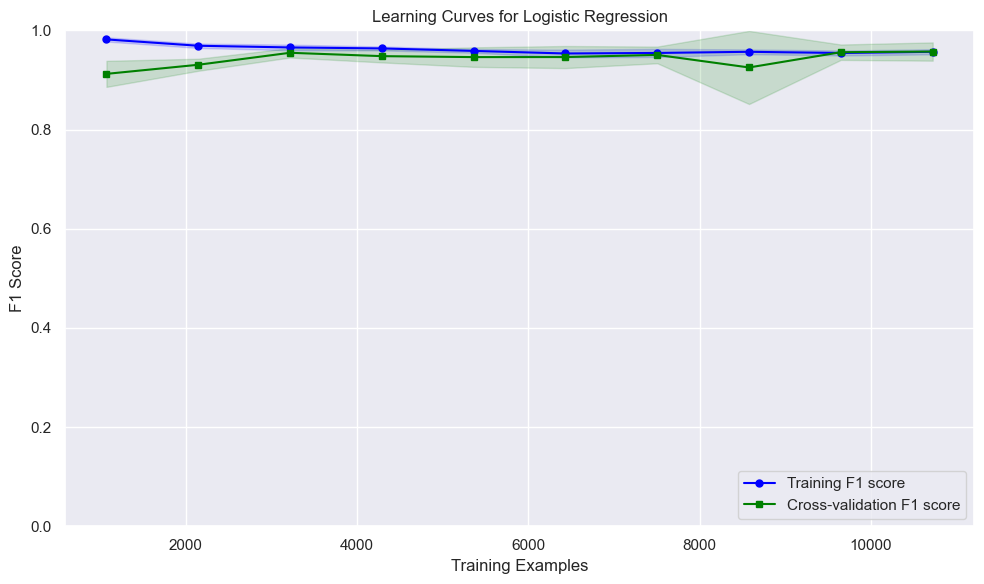


Overfitting assessment:
F1 score gap: 8.48% higher on training set than testing set
Verdict: Model shows moderate overfitting (5-15% gap)

Cross-validation scores:
Mean CV F1 score: 0.9574 (±0.0184)

=== Overfitting Summary ===
Performance gap: 8.48%
Cross-validation mean F1: 0.9574 (±0.0184)

=== Minor Adjustments to Consider ===
1. Slight increase in regularization parameters
2. Consider using early stopping in future iterations


In [63]:
## 6.5. Test for Model Overfitting

from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def check_for_overfitting(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Comprehensive check for overfitting by comparing training and testing performance
    and plotting learning curves.
    
    Args:
        model: Trained model to evaluate
        X_train: Training features
        y_train: Training target
        X_test: Testing features
        y_test: Testing target
        model_name: Name of the model for plotting
    """
    # 1. Compare metrics on training vs testing data
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    if y_train_pred_proba is not None and y_test_pred_proba is not None:
        train_metrics['roc_auc'] = roc_auc_score(y_train, y_train_pred_proba)
        test_metrics['roc_auc'] = roc_auc_score(y_test, y_test_pred_proba)
    
    # Print comparison
    print(f"===== Overfitting Analysis for {model_name} =====")
    print("\nTraining vs Testing Performance:")
    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Testing': test_metrics,
        'Difference': {k: train_metrics[k] - test_metrics[k] for k in train_metrics}
    }).T
    
    print(metrics_df.round(4))
    
    # Visualization of training vs testing performance
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    metrics = list(train_metrics.keys())
    x = np.arange(len(metrics))
    
    plt.bar(x - bar_width/2, list(train_metrics.values()), bar_width, label='Training')
    plt.bar(x + bar_width/2, list(test_metrics.values()), bar_width, label='Testing')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'{model_name}: Training vs Testing Performance')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 2. Learning curves
    print("\nGenerating learning curves...")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='f1', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, 
             label='Training F1 score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, 
             label='Cross-validation F1 score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    
    plt.title(f'Learning Curves for {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # 3. Calculate overfitting score - ratio of performance difference
    performance_gap = (train_metrics['f1'] - test_metrics['f1']) / train_metrics['f1'] * 100
    print(f"\nOverfitting assessment:")
    print(f"F1 score gap: {performance_gap:.2f}% higher on training set than testing set")
    
    if performance_gap < 5:
        print("Verdict: Model shows minimal signs of overfitting (<5% gap)")
    elif performance_gap < 15:
        print("Verdict: Model shows moderate overfitting (5-15% gap)")
    else:
        print("Verdict: Model likely suffers from significant overfitting (>15% gap)")
        
    # 4. Cross-validation scores
    print("\nCross-validation scores:")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'performance_gap': performance_gap,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

# Testing for overfitting in our XGBoost model (best model)
print("\n\n## Testing for Model Overfitting")
overfitting_results = check_for_overfitting(
    best_model,  # This is the model identified as best earlier
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name=best_model_name
)

# Print overfitting summary
print("\n=== Overfitting Summary ===")
print(f"Performance gap: {overfitting_results['performance_gap']:.2f}%")
print(f"Cross-validation mean F1: {overfitting_results['cv_mean']:.4f} (±{overfitting_results['cv_std']:.4f})")

# If there is substantial overfitting, suggest remediation strategies
if overfitting_results['performance_gap'] > 15:
    print("\n=== Recommendations to Reduce Overfitting ===")
    print("1. Increase regularization (increase reg_alpha and reg_lambda parameters)")
    print("2. Reduce model complexity (decrease max_depth, min_child_weight)")
    print("3. Use early stopping during training")
    print("4. Add more training data if possible")
    
    # Specific XGBoost parameters to adjust if XGBoost is the best model
    if best_model_name == "XGBoost":
        print("\nSuggested XGBoost parameter adjustments:")
        print("xgb_params = {")
        print("    'max_depth': 3,  # Reduce from current value")
        print("    'min_child_weight': 5,  # Increase from current value")
        print("    'gamma': 1,  # Increase minimum loss reduction for partition")
        print("    'reg_alpha': 1,  # L1 regularization")
        print("    'reg_lambda': 2,  # L2 regularization")
        print("    'subsample': 0.8,  # Use 80% of data per tree")
        print("    'colsample_bytree': 0.8  # Use 80% of features per tree")
        print("}")
elif overfitting_results['performance_gap'] > 5:
    print("\n=== Minor Adjustments to Consider ===")
    print("1. Slight increase in regularization parameters")
    print("2. Consider using early stopping in future iterations")
else:
    print("\n=== Model Generalizes Well ===")
    print("Your model shows minimal signs of overfitting. Good job!")
    print("You can proceed to model deployment or further optimization.")

In [64]:
## 6.6 Check for Train-Test Data Contamination

print("\n\n== Checking for Train-Test Data Separation Issues ==")

# 1. Check for exact duplicates between train and test sets
train_rows = X_train.shape[0]
test_rows = X_test.shape[0]
print(f"Training set rows: {train_rows}, Test set rows: {test_rows}")

# Combine datasets with source labels to check for overlap
X_train_marked = X_train.copy()
X_train_marked['data_source'] = 'train'
X_test_marked = X_test.copy()
X_test_marked['data_source'] = 'test'

combined_data = pd.concat([X_train_marked, X_test_marked])
print(f"Combined shape: {combined_data.shape}")

# Check if combined data has fewer rows than the sum (indicating duplicates)
expected_rows = train_rows + test_rows
actual_rows = combined_data.shape[0]
if actual_rows < expected_rows:
    print(f"WARNING: Found {expected_rows - actual_rows} duplicate rows between training and test sets")
else:
    print("No exact duplicates found between train and test sets")

# 2. Check for near-duplicates by sampling a few rows from test set
print("\nChecking for near-duplicates between sets...")
sample_size = min(5, test_rows)
test_samples = X_test.sample(n=sample_size, random_state=42)

for i, test_row in enumerate(test_samples.itertuples()):
    # Convert test row to array for comparison
    test_array = np.array(test_row[1:])
    
    # Calculate distances to all training samples
    distances = np.linalg.norm(X_train.values - test_array, axis=1)
    min_distance = np.min(distances)
    min_idx = np.argmin(distances)
    
    print(f"Test sample {i+1}: Minimum distance to training set = {min_distance:.6f}")
    
    # If very similar rows exist, this could indicate data leakage
    if min_distance < 0.001:
        print("WARNING: Found nearly identical rows between train and test sets!")
        print("Test row:")
        print(test_samples.iloc[i])
        print("\nNearest training row:")
        print(X_train.iloc[min_idx])

# 3. Check that we're not using future information to predict the past
if 'admission_count' in X_train.columns:
    print("\nChecking time-based features...")
    # Sort by admission count or date-related features if available
    print("Average admission_count in train set:", X_train['admission_count'].mean())
    print("Average admission_count in test set:", X_test['admission_count'].mean())
    
    if 'days_since_last_admission' in X_train.columns:
        print("Average days_since_last_admission in train:", X_train['days_since_last_admission'].mean())
        print("Average days_since_last_admission in test:", X_test['days_since_last_admission'].mean())

# 4. Check preprocessing validity
target_distribution_train = y_train.mean()
target_distribution_test = y_test.mean()
print(f"\nTarget distribution in train: {target_distribution_train:.4f}")
print(f"Target distribution in test: {target_distribution_test:.4f}")
print(f"Difference: {abs(target_distribution_train - target_distribution_test):.4f}")

if abs(target_distribution_train - target_distribution_test) > 0.1:
    print("WARNING: Train and test sets have substantially different target distributions")

print("\nVerify that training and test preprocessing was done separately (not shown in code)")
print("Ensure that:") 
print("1. Feature scaling/normalization was fit only on training data")
print("2. Any feature selection was performed only on training data")
print("3. Target encoding or other data transformations didn't use test data")



== Checking for Train-Test Data Separation Issues ==
Training set rows: 13404, Test set rows: 3352
Combined shape: (16756, 13)
No exact duplicates found between train and test sets

Checking for near-duplicates between sets...
Test sample 1: Minimum distance to training set = 558.604562
Test sample 2: Minimum distance to training set = 495.039112
Test sample 3: Minimum distance to training set = 339.865285
Test sample 4: Minimum distance to training set = 602.841892
Test sample 5: Minimum distance to training set = 700.716285

Checking time-based features...
Average admission_count in train set: 1.2336615935541628
Average admission_count in test set: 4.639319809069212
Average days_since_last_admission in train: 128.6459751338738
Average days_since_last_admission in test: 290.2912293241183

Target distribution in train: 0.0821
Target distribution in test: 0.1587
Difference: 0.0766

Verify that training and test preprocessing was done separately (not shown in code)
Ensure that:
1. Feat

## 7. Conclusion and Next Steps

In this notebook, we trained and evaluated three different models for predicting 30-day readmissions for heart failure patients:
- Logistic Regression (baseline)
- Random Forest
- XGBoost

Key observations:
1. Performance comparison between models
2. Most important features for predicting readmissions based on both model-specific importance and SHAP values
3. Detailed interpretation of how features affect predictions
4. Areas for model improvement

Next steps:
1. Hyperparameter tuning for the best model
2. Feature engineering to focus on high-impact variables
3. Model deployment as an inference pipeline
4. Clinical validation of findings